<a href="https://colab.research.google.com/github/jhyeon-kim/ai_study/blob/main/%EC%9D%8C%EC%95%85_%EA%B0%90%EC%A0%95_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_%EC%82%AC%EC%9A%A9_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio

In [2]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification

# 감정 범주 정의 (각 레이블에 해당하는 감정 이름)
emotion_labels = ["😡 Angry", "😱 Fear", "😃 Happy", "😊 Tender", "😢 Sad"]

# Hugging Face에서 모델을 불러와 예측하는 함수
def predict_emotion_from_audio(model, audio_file_path, target_sample_rate=16000, segment_length=80000):
    model.eval()  # 평가 모드로 설정

    # 오디오 파일 로드
    waveform, sample_rate = torchaudio.load(audio_file_path)

    # 리샘플링 (필요한 경우)
    if sample_rate != target_sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)

    # 스테레오 데이터를 모노로 변환
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # 5초 분량이 아니면 자르거나 패딩 (필요시)
    if waveform.shape[1] > segment_length:
        waveform = waveform[:, :segment_length]
    else:
        pad_size = segment_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_size))

    # Mel Spectrogram 변환
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=target_sample_rate, n_mels=64)
    spec = mel_spectrogram(waveform)

    # 차원 맞추기 (batch dimension 추가)
    spec = spec.unsqueeze(0)  # [1, 1, n_mels, time]

    # 모델에 입력하고 예측
    with torch.no_grad():
        output = model(spec.to(device))
        probabilities = F.softmax(output, dim=1)  # 확률로 변환
        _, predicted = torch.max(output, 1)  # 가장 높은 확률의 감정 선택

    # 결과 출력
    predicted_emotion = emotion_labels[predicted.item()]
    class_probabilities = probabilities.cpu().numpy()[0]

    print(f"Predicted Emotion: {predicted_emotion}")
    print("Probabilities for each emotion category:")
    for idx, label in enumerate(emotion_labels):
        print(f"{label}: {class_probabilities[idx]:.2f}")

    # 막대 그래프로 감정별 확률 시각화
    display_emotion_probabilities(class_probabilities, emotion_labels)

# 감정별 확률을 시각화하는 함수
def display_emotion_probabilities(probabilities, emotion_labels):
    plt.figure(figsize=(8, 5))
    plt.bar(emotion_labels, probabilities, color='skyblue')
    plt.ylim([0, 1])
    plt.title("Emotion Prediction Probabilities")
    plt.xlabel("Emotion")
    plt.ylabel("Probability")
    plt.show()

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=5):  # 감정 분류 클래스 수
        super(CNNEmotionClassifier, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 50, 256)  # 128 * 8 * 50 = 51200
        self.fc2 = nn.Linear(256, num_classes)  # 감정 분류 레이블 수

    def forward(self, x):
        # 입력 데이터 크기: [batch_size, 1, 64, time]
        x = self.pool(F.relu(self.conv1(x)))  # (N, 32, 64, time/2)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 64, 32, time/4)
        x = self.pool(F.relu(self.conv3(x)))  # (N, 128, 16, time/8)

        # CNN 출력 후 크기 출력
        # print(f"After conv3: {x.shape}")

        # Flatten: Conv 레이어의 출력을 1D로 변환
        x = x.view(x.size(0), -1)  # Flatten (N, 128 * 8 * 50 = 51200)
        # print(f"After flatten: {x.shape}")

        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
from huggingface_hub import hf_hub_download
import torch

# GPU가 사용 가능하면 GPU로 모델 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hugging Face 저장소에서 PyTorch 모델 불러오기
model_name = "jeonghyeon97/music_emontion_classifier_4"
filename = "pytorch_model.bin"  # 업로드한 파일 이름

# Hugging Face Hub에서 모델 다운로드
model_path = hf_hub_download(repo_id=model_name, filename=filename)

# 모델 로드
model = CNNEmotionClassifier(num_classes=5)
model.load_state_dict(torch.load(model_path))
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/52.8M [00:00<?, ?B/s]

<ipython-input-4-e15409942a3b>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


CNNEmotionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=51200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

Predicted Emotion: 😃 Happy
Probabilities for each emotion category:
😡 Angry: 0.01
😱 Fear: 0.00
😃 Happy: 0.72
😊 Tender: 0.26
😢 Sad: 0.00


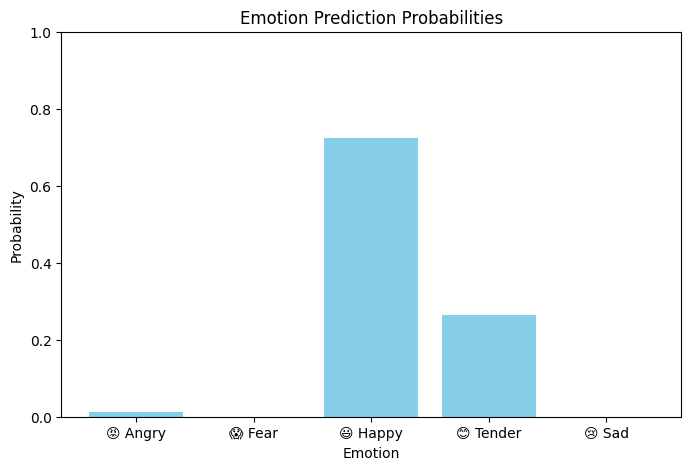

In [6]:
audio_file_path = "/content/smile.mp3"
predict_emotion_from_audio(model, audio_file_path)